# Libraries

In [92]:
from src import data # dataset functions
import pandas as pd # dataframes
import numpy as np # linear algebra
from bs4 import BeautifulSoup # html parser
import re # regular expressions
from nltk.tokenize import word_tokenize # tokenizing

# visualization
import matplotlib.pyplot as plt # plotting
import seaborn as sns # high level api for matplotlib
import seaborn.objects as so # grammar of graphics

In [2]:
# plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Datasets

In [3]:
data_directory = '../../../../data/04_pubmed'
datasets = data.dict_from_directory(data_directory)

# General Characteristics

Save one DataFrame to a variable to inspect its structure

In [4]:
# subject & data of the first dataset
subject, dataframe = next(iter(datasets.items()))
print(f'accessing the first dataset: {subject}')

accessing the first dataset: adhd


Print the first few lines

In [5]:
dataframe.head()

,include,title,abstract,doi,literature_id,openalex_id
0,False,The effectiveness of clonidine as an analgesic...,To compare the analgesic effects of preoperati...,https://doi.org/10.1007/bf03012457,10051933,https://openalex.org/W2082613933
1,False,A Controlled Trial of Sustained-Release Buprop...,Use of nicotine-replacement therapies and the ...,https://doi.org/10.1056/nejm199903043400903,10053177,https://openalex.org/W2312609348
2,False,Effects of methylphenidate on complex cognitiv...,Three experiments were conducted to explore th...,https://doi.org/10.1037/0021-843x.108.1.90,10066996,https://openalex.org/W2022904832
3,False,Spinal Clonidine Prolongs Labor Analgesia from...,We sought to determine whether spinal clonidin...,https://doi.org/10.1097/00000539-199903000-00020,10072008,https://openalex.org/W2021097359
4,False,Low-Dose Clozapine for the Treatment of Drug-I...,Drug-induced psychosis is a difficult problem ...,https://doi.org/10.1056/nejm199903113401003,10072410,https://openalex.org/W4239283954


Index, dtypes, columns, non-null values and memory usage 

In [6]:
# calculate the memory usage insted of estimating it
dataframe.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   include        851 non-null    boolean
 1   title          851 non-null    string 
 2   abstract       830 non-null    string 
 3   doi            780 non-null    string 
 4   literature_id  851 non-null    Int64  
 5   openalex_id    843 non-null    string 
dtypes: Int64(1), boolean(1), string(4)
memory usage: 2.0 MB


- Records contain the label (include), title and abstract and multiple identifiers
- The label is a boolean, the other columns are strings or numbers
- The dataframe takes 2 MB of memory

# Special Characteristics

In [36]:
pd.options.display.max_colwidth = 150

## Languages
There are abstracts in German and Japanese. As the models will not be able to handle multiple languages, we need to handle languages other than English.
As non-English entries are relatively rare, we can safely drop these few rows.

In [35]:
pd.concat([
    datasets['pancreatic_surgery'][['abstract']].iloc[200],
    datasets['atypical_antipsychotics'][['abstract']].iloc[99]
], axis=1).transpose()

,abstract
200,Zusammenfassung Hintergrund Die chronische Pankreatitis (CP) ist eine haufige Ursache fur stationare Einweisungen in die Gastroenterologie und ist...
99,シグマ受容体拮抗物質に関する最近の研究成果を精神分裂病治療薬との関連でまとめた．選択的シグマ1受容体拮抗物質であるNE-100はphencyclidine(PCP)誘発異常行動改善作用および認知障害改善作用を有するが，ドパミンアゴニスト誘発行動には影響を及ぼさず，カタレプシー惹起性も認められ...


## Noise
The following examples demonstrate kinds of noise that make complicate classification for the models.

### HTML Tags


In [37]:
pd.concat([
    datasets['calcium_channel_blockers'][['abstract']].iloc[[24]],
    datasets['adhd'][['abstract']].iloc[[456, 565]]
])

,abstract
24,<h3>Objective:</h3> To report an atypical presentation of Lance-Adams Syndrome presenting from severe respiratory depression rather than cardiac a...
456,<b><i>Objective:</i></b> To evaluate the efficacy and safety of risperidone in children and adults with Tourette syndrome. <b><i>Methods:</i></b> ...
565,<h3>Objective:</h3> To compare the intraocular pressure (IOP) lowering efficacy of 0.5% and 1.0% apraclonidine hydrochloride when used adjunctivel...


We can get rid of HTML using the Beautiful Soup library, e.g. the article with index 456 from above:

In [74]:
BeautifulSoup(datasets['adhd'].iloc[456]['abstract'], 'lxml').get_text()

'Objective: To evaluate the efficacy and safety of risperidone in children and adults with Tourette syndrome. Methods: This was an 8-week, randomized, double-blind, placebo-controlled trial. The primary outcome measure was the Total Tic score of the Yale Global Tic Severity Scale (YGTSS). Results: Thirty-four medication-free subjects (26 children and 8 adults) ranging in age from 6 to 62 years (mean = 19.7 ± 17.0 years) participated. YGTSS Total Tic scores were similar at baseline (26.0 ± 5.1 for risperidone vs 27.4 ± 8.5 for placebo). After 8 weeks of treatment (mean daily dose of 2.5 ± 0.85), the 16 subjects on risperidone showed a 32% reduction in tic severity from baseline, compared to a 7% reduction for placebo patients (n = 18) (F[2,64] = 6.07; p = 0.004). The 12 children randomized to risperidone showed a 36% reduction in tic symptoms compared to an 11% decrease in the 14 children on placebo (F[2,48] = 6.38; p = 0.004). Two children on risperidone showed acute social phobia, whi

### Markdown Headings

In [85]:
datasets['calcium_channel_blockers'].iloc[[44]][['abstract']]

,abstract
44,### Table of contents It is important that the medical profession play a significant role in critically evaluating the use of diagnostic proced...


Markdown headings are defined by a number of subsequent '#'

Regular expressions can filter any sequence from zero to unlimited characters:

In [115]:
no_headings = re.sub(r'(#)+', '', datasets['calcium_channel_blockers'].iloc[[44]]['abstract'].values[0])
no_headings

' Table of contents\r\n\r\nIt is important that the medical profession play a significant role in critically evaluating the use of diagnostic procedures and therapies in the management or prevention of disease states. Rigorous and expert analysis of the available data documenting relative benefits and'

The transformation made a carriage return visible. This can also be riddened of by regular expressions:

In [114]:
re.sub(r'(\r\n\r\n)+', ' ', no_headings)

' Table of contents It is important that the medical profession play a significant role in critically evaluating the use of diagnostic procedures and therapies in the management or prevention of disease states. Rigorous and expert analysis of the available data documenting relative benefits and'

In [117]:
re.sub(r'(\\r)+(\\n)+', ' ', no_headings)

' Table of contents\r\n\r\nIt is important that the medical profession play a significant role in critically evaluating the use of diagnostic procedures and therapies in the management or prevention of disease states. Rigorous and expert analysis of the available data documenting relative benefits and'

### Special Characters
Other special characters are also possible

In [41]:
datasets['animal_depression'].iloc[190]['abstract']

'✓ Adult Fisher 344 rats were subjected to a unilateral impact to the dorsal cortex above the hippocampus at 3.5 m/second, resulting in a 2-mm cortical depression. This caused severe cortical damage and neuronal loss in hippocampus subfields CA1, CA3, and hilus. Breakdown of the blood-brain barrier (BBB) was assessed by injecting the protein horseradish peroxidase (HRP) 5 minutes prior to or at various times after injury (5 minutes, 1, 3, 6, and 12 hours, 1, 2, 5, and 10 days). Animals were killed 1 hour after HRP injection and brain sections were reacted with diaminobenzidine to visualize extravascular accumulation of the protein. Maximum staining occurred in animals injected with HRP 5 minutes prior to or 5 minutes after cortical contusion. Staining at these time points was observed in the ipsilateral cortex of the impact area and areas adjacent to it, as well as in the ipsilateral hippocampus. Some modest staining occurred in the dorsal contralateral cortex near the superior sagitta

Another approach of eliminating unwanted characters is to tokenize the text and filter by using a list of unwanted tokens:

In [98]:
tokenized = word_tokenize(datasets['animal_depression'].iloc[190]['abstract'])
stopwords = ['✓']

[word for word in tokenized if word.lower() not in stopwords][:6] + ['...']

['Adult', 'Fisher', '344', 'rats', 'were', 'subjected', '...']

### Abbreviations
You commonly find abbreviations in scientific texts.

In [44]:
datasets['pancreatic_surgery'].iloc[[1,6,249]][['abstract']]

,abstract
1,The importance of diagnostic endoscopic retrograde cholangiography (ERCP) has dramatically decreased owing to the development of less invasive tec...
6,INTRODUCTION: Pancreaticopleural fistula (PPF) is a rare but serious complication of pancreatic disorders. As the clinical presentations of PPF ar...
249,"Intravenous radionuclide cholescintigraphy (IVRC) provides a very specific picture for choledochal cysts. However, the clinical significance of th..."


However, because their meaning may differ between articles, we remove them to make the text less ambiguous.

Abbreviations usually follow the format of two or more uppercase letters, surrounded by parantheses.
We can use this format convention to filter out abbreviations using regular expressions:

In [110]:
remove_abbreviations = r'(\([A-Z]{2,}\))'# at least two uppercase letters in parentheses
sample = datasets['pancreatic_surgery'].iloc[[1]]['abstract'].values[0]

re.sub(remove_abbreviations, '', sample)

'The importance of diagnostic endoscopic retrograde cholangiography  has dramatically decreased owing to the development of less invasive techniques such as ultrasonography, computed tomography, endoscopic ultrasonography, and finally magnetic resonance cholangiopancreatography . MRCP is becoming the gold standard in the diagnostic work-up of the pancreaticobiliary duct. However, MRCP cannot solve all the problems that occur, and still has inadequate resolution for small stones and tiny pancreatic and bile duct lesions. ERCP continues to be useful in difficult cases and when the diagnosis is uncertain, particularly when fluid collection and tissue sampling are necessary. However, several alternatives to sphincter of Oddi manometry have been proposed. Finally, ERCP is always the first step before endoscopic treatment, which in contrast to diagnostic ERCP is still widely used.'

## Duplicates
There appear many duplicates when searching for articles with the same title. There are however different cases that require individual handling:

### Same article published twice
The following example shows an identical article that was published twice. Because the two articles are identical, we can safely delete one of them.

In [46]:
datasets['pancreatic_surgery'].iloc[[12250,12322]]

,include,title,abstract,doi,literature_id,openalex_id
12250,False,β-cell failure in type 2 diabetes: postulated mechanisms and prospects for prevention and treatment.,OBJECTIVE: This article examines the foundation of β-cell failure in type 2 diabetes (T2D) and suggests areas for future research on the underlyin...,10.1210/jc.2014-1425,24712577,<NA>
12322,False,β-cell failure in type 2 diabetes: postulated mechanisms and prospects for prevention and treatment.,OBJECTIVE: This article examines the foundation of β-cell failure in type 2 diabetes (T2D) and suggests areas for future research on the underlyin...,10.2337/dc14-0396,24812433,<NA>


### Same title but different articles
Another case are articles that share a title but are clearly distinguishable through their content, doi and literature id. As those two articles differ in content, we try to keep both.

In [47]:
datasets['oral_hypoglycemics'].iloc[[178,179]]

,include,title,abstract,doi,literature_id,openalex_id
178,False,Oral Antihyperglycemic Therapy for Type 2 Diabetes,"Diabetes mellitus affects more than 6% of the US population, with the great majority having type 2 diabetes mellitus (DM). 1 In some older groups,...",https://doi.org/10.1001/jama.287.3.360,11790216,https://openalex.org/W2069150029
179,False,Oral Antihyperglycemic Therapy for Type 2 Diabetes,"Oral agents are the mainstay of pharmacologic treatment for type 2 diabetes, and physicians now have a number of agents to choose from. However, m...",https://doi.org/10.1001/jama.287.3.373,11790217,https://openalex.org/W1988203022


### Same title and abstract but different literature_id

In [68]:
datasets['pancreatic_surgery'].iloc[[1421, 4664, 4666, 4668, 14868, 32546, 32935]]

,include,title,abstract,doi,literature_id,openalex_id
1421,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,<NA>,WOS:A1992HY79500019,<NA>
4664,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,10.1016/S0016-5107(92)70486-6,WOS:A1992JJ19200021,<NA>
4666,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,<NA>,WOS:A1992JJ53700003,<NA>
4668,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,<NA>,WOS:A1992JL18000002,<NA>
14868,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,<NA>,WOS:A1992HV16000003,<NA>
32546,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,<NA>,WOS:A1992HH62100002,<NA>
32935,False,Serological differences between some isolates of bean yellow mosaic virus.,The degree of serological relatedness of three isolates of bean yellow mosaic virus (BYMV) was studied. One common antigenic group (m) was demonst...,10.1016/0016-5085(92)91195-A,WOS:A1992JV47800035,<NA>


### Same title but different labels
- Following the literature_id reveals different titles

In [55]:
datasets['pancreatic_surgery'].iloc[[30701, 32679, 32680, 32853, 33022, 33088, 33119]]

,include,title,abstract,doi,literature_id,openalex_id
30701,True,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,<NA>,WOS:A1997YL29400007,<NA>
32679,False,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,10.1016/S1053-4296(97)80053-7,WOS:A1997XM14200001,<NA>
32680,False,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,<NA>,WOS:A1997XM38400008,<NA>
32853,False,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,<NA>,WOS:A1997YK06400008,<NA>
33022,False,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,10.1016/S0039-6060(97)90175-6,WOS:A1997WC21200001,<NA>
33088,True,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,<NA>,WOS:A1997WV41901011,<NA>
33119,True,Selection of chlortetracycline-resistant strain of Coxiella burnetii.,<NA>,<NA>,WOS:A1997WV41905901,<NA>


## Paragraph Labels

In [112]:
pd.concat([
    datasets['pancreatic_surgery'].iloc[[3,4,6,9,12,13,19,21,23,31,307,343,399,430,533,656,876,]][['abstract']],
    datasets['atypical_antipsychotics'].iloc[[24]][['abstract']],
    datasets['adhd'].iloc[[39]][['abstract']]
])

,abstract
3,BACKGROUND: Gastric lipase contributes significantly to overall lipolysis and is regulated by interacting neuro-hormonal mechanisms. Patients with...
4,BACKGROUND/AIM: The pancreas is an organ highly susceptible to ischemic damage. This discussion reviews the role of ischemia as an etiologic facto...
6,INTRODUCTION: Pancreaticopleural fistula (PPF) is a rare but serious complication of pancreatic disorders. As the clinical presentations of PPF ar...
9,UNLABELLED: Tacrolimus (FK-506) is an immunosuppressant agent that acts by a variety of different mechanisms which include inhibition of calcineur...
12,INTERVENTION: Precompression of pancreatic parenchyma with intestinal clamp. Without Precompression CONDITION: Patients who underwent distal pancr...
13,Objective The aim of this study was to report on the short-and long-term outcomes of surgery for chronic pancreatitis (CP) in children. Methods Al...
19,"Although type 1 and type 2 diabetes represent the vast majority of affected individuals with the disease, not all cases of diabetes fit neatly int..."
21,OBJECTIVE: The ISGPS aimed to develop a universally accepted definition for PPAP for standardized reporting and outcome comparison. BACKGROUND: PP...
23,"OBJECTIVE: To review the current literature pertaining to the pathophysiology, diagnosis, and treatment of injuries sustained from high-rise syndr..."
31,BACKGROUNDS/OBJECTIVES: Patients with chronic pancreatitis may develop pancreatic duct stones that can obstruct outflow leading to ductal hyperten...


# Missing Values

- How many titles and abstracts are missing?
- How many more were missing before downloading data from PubMed?

In [9]:
data_directory_before = '../../../../data/03_openalex'
datasets_before = data.dict_from_directory(data_directory_before)

Calculate missing titles & abstracts before and after the data retrieval:

In [10]:
missing_percentages = lambda x: round(x.isna().mean() * 100, 2)

In [11]:
missings_before = pd.DataFrame({
    'dataset': subject,
    'title': missing_percentages(df['title']),
    'abstract': missing_percentages(df['abstract']),
    'preprocessing': 'before'
}for subject, df in datasets_before.items())

In [12]:
missings_after = pd.DataFrame({
    'dataset': subject,
    'title': missing_percentages(df['title']),
    'abstract': missing_percentages(df['abstract']),
    'preprocessing': 'after'
}for subject, df in datasets.items())

In [13]:
missings = pd.concat([missings_before, missings_after])

missings_long = pd.melt(missings, id_vars=['dataset', 'preprocessing'], value_vars=['title', 'abstract'],
                        var_name='type', value_name='missing')

missings_long.sort_values(by='preprocessing', ascending=True, inplace=True)

missings_long

,dataset,preprocessing,type,missing
11,pancreatic_surgery,after,title,0.02
21,calcium_channel_blockers,after,abstract,3.53
20,atypical_antipsychotics,after,abstract,2.59
19,animal_depression,after,abstract,12.84
18,adhd,after,abstract,2.47
22,oral_hypoglycemics,after,abstract,3.78
10,oral_hypoglycemics,after,title,0.00
9,calcium_channel_blockers,after,title,0.00
23,pancreatic_surgery,after,abstract,8.74
7,animal_depression,after,title,2.71


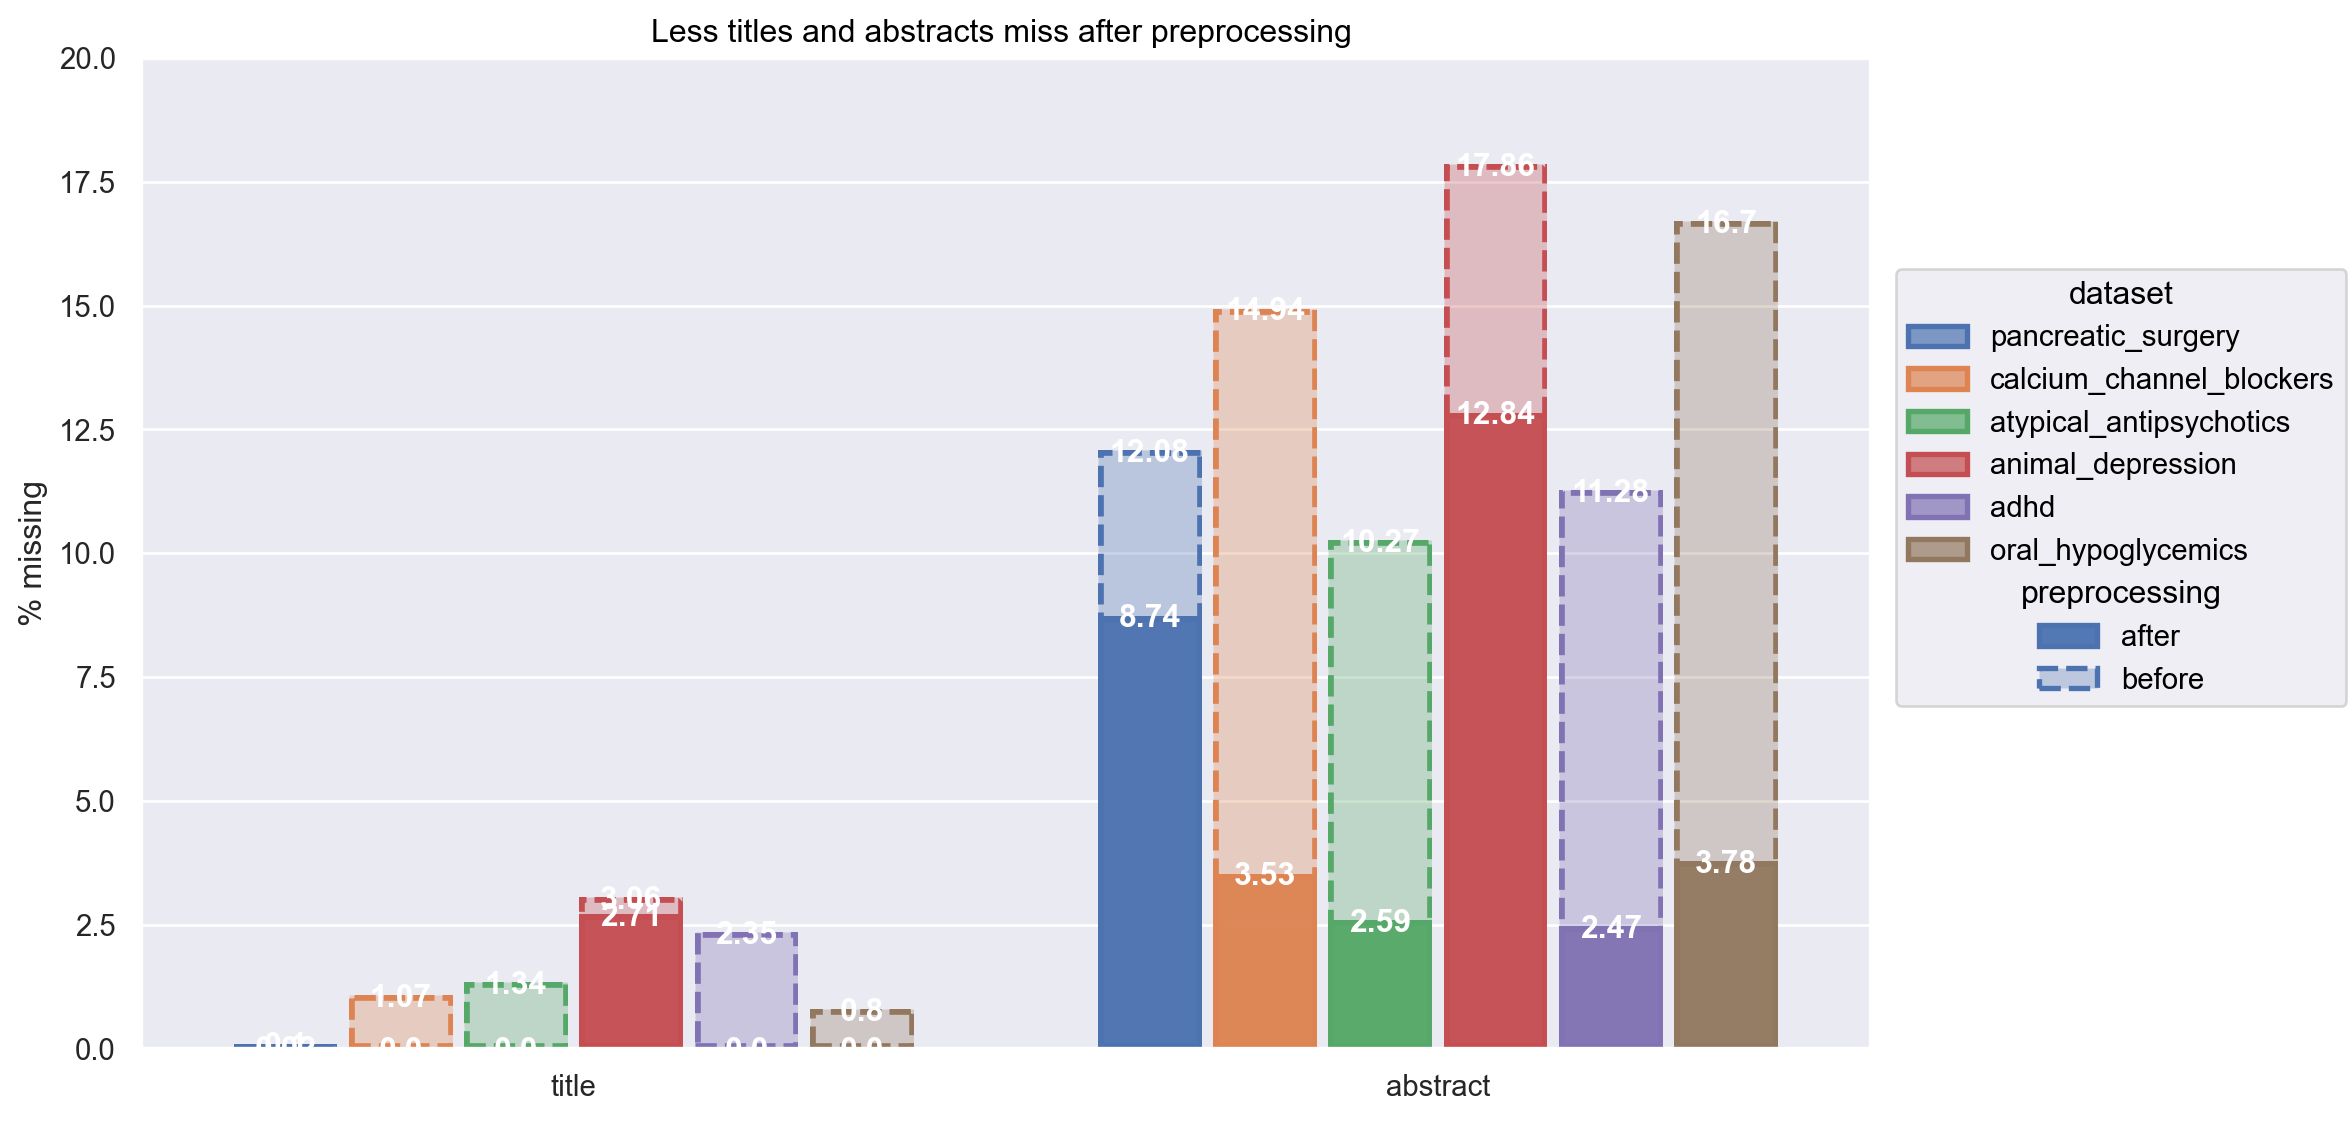

In [14]:
(
    so.Plot(data=missings_long, x='type', y='missing', color='dataset', alpha='preprocessing', edgestyle='preprocessing', text='missing')
    .add(so.Bar(edgewidth=2), so.Dodge(by=['color'], gap=0.1))
    .add(so.Text({"fontweight": "bold"}, color='w', alpha=1), so.Dodge(by=['color']))
    .label(x='', y='% missing', title='Less titles and abstracts miss after preprocessing ', legend='Test')
    .scale()
    .layout(size=(10, 6))
    .limit(y=(0,20))
)

# Label Distributions

In [15]:
frequency_distribution = lambda x: x.value_counts(normalize=True)

In [16]:
distributions = pd.DataFrame({
    'dataset': subject,
    'include ': round((df.include.pipe(frequency_distribution)[True] * 100), 2),
    'exclude': round((df.include.pipe(frequency_distribution)[False] * 100), 2),
}for subject, df in datasets.items())

## Display the percentages of distributions in a table

In [17]:
distributions

,dataset,include,exclude
0,adhd,2.35,97.65
1,animal_depression,14.05,85.95
2,atypical_antipsychotics,13.04,86.96
3,calcium_channel_blockers,8.21,91.79
4,oral_hypoglycemics,27.04,72.96
5,pancreatic_surgery,6.88,93.12


## Plot a graph with the inclusion percentages

In [18]:
distributions_melted = distributions.melt(id_vars='dataset', value_name='percentage')
distributions_melted.sort_values(by='percentage', ascending=False, inplace=True)
distributions_melted

,dataset,variable,percentage
6,adhd,exclude,97.65
11,pancreatic_surgery,exclude,93.12
9,calcium_channel_blockers,exclude,91.79
8,atypical_antipsychotics,exclude,86.96
7,animal_depression,exclude,85.95
10,oral_hypoglycemics,exclude,72.96
4,oral_hypoglycemics,include,27.04
1,animal_depression,include,14.05
2,atypical_antipsychotics,include,13.04
3,calcium_channel_blockers,include,8.21


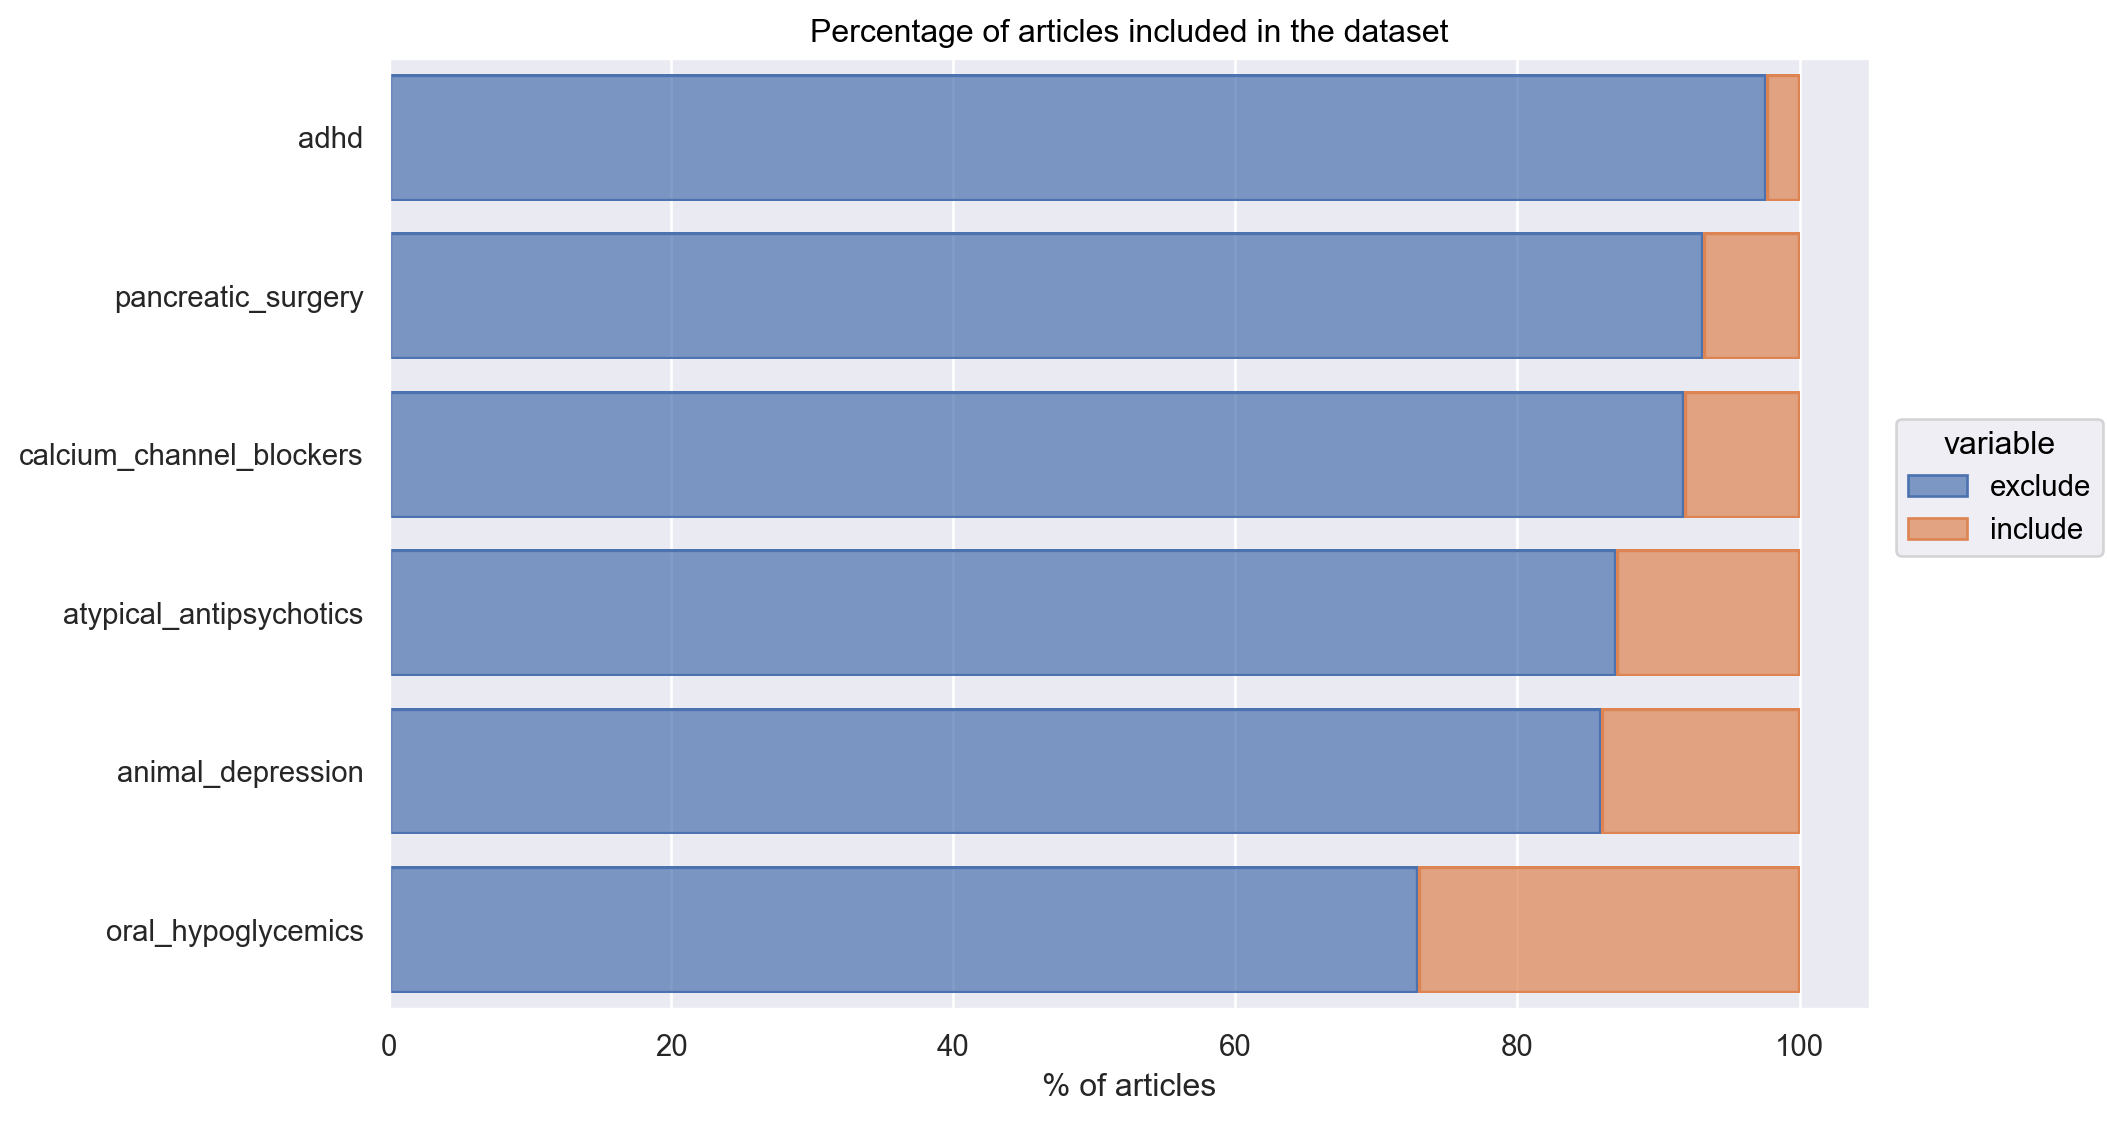

In [19]:
(
    so.Plot(data=distributions_melted, y='dataset', x='percentage', color='variable')
    .add(so.Bar(), so.Stack())
    .label(y='', x='% of articles', title='Percentage of articles included in the dataset')
    .layout(size=(10, 6))
)

# Text Specific Analyses

## Noise Inspection

In [20]:
a = datasets['pancreatic_surgery']
a

,include,title,abstract,doi,literature_id,openalex_id
0,False,Reflections and proposals for the standardization of lymphadenectomy for gastric carcinoma.,"In this paper, I consider: the value of various histological procedures; the feasibility and rep...",10.1053/ejso.1999.0731,10718171,<NA>
1,False,Diagnostic endoscopic retrograde cholangiopancreatography.,The importance of diagnostic endoscopic retrograde cholangiography (ERCP) has dramatically decre...,10.1055/s-2000-95,10718385,<NA>
2,False,Therapeutic pancreatic endoscopy.,A number of endoscopic interventions have expanded the range of treatment options in symptomatic...,10.1055/s-2000-94,10718387,<NA>
3,False,Cephalic phase of lipolysis is impaired in pancreatic insufficiency: role of gastric lipase.,BACKGROUND: Gastric lipase contributes significantly to overall lipolysis and is regulated by in...,10.1080/003655200750024407,10720121,<NA>
4,False,Ischemia/Reperfusion-Induced pancreatitis.,BACKGROUND/AIM: The pancreas is an organ highly susceptible to ischemic damage. This discussion ...,10.1159/000018793,10720825,<NA>
...,...,...,...,...,...,...
34201,True,Quality of life after open versus laparoscopic distal pancreatectomy: long-term results from a r...,BACKGROUND: Pancreatic surgery is rapidly transitioning towards minimally invasive methods. Posi...,10.1093/bjsopen/zrad002,36893287,<NA>
34202,True,A randomized controlled trial evaluating effects of prophylactic irrigation-suction near pancrea...,BACKGROUND: Clinically relevant postoperative pancreatic fistula (CR-POPF) is a common complicat...,10.1007/s00423-023-02873-w,37010643,<NA>
34203,True,Minimally invasive versus open distal pancreatectomy for resectable pancreatic cancer (DIPLOMA):...,BACKGROUND: The oncological safety of minimally invasive surgery has been questioned for several...,10.1016/j.lanepe.2023.100673,37457332,<NA>
34204,True,A prospective randomized controlled trial of internal versus external drainage with pancreaticoj...,"BACKGROUND: A stent often is placed across the pancreaticojejunostomy. However, there is no repo...",10.1016/j.amjsurg.2009.04.017,20074698,<NA>


In [21]:
b = datasets['adhd']
b

,include,title,abstract,doi,literature_id,openalex_id
0,False,The effectiveness of clonidine as an analgesic in paediatric adenotonsillectomy,To compare the analgesic effects of preoperative oral clonidine with intraoperative intravenous ...,https://doi.org/10.1007/bf03012457,10051933,https://openalex.org/W2082613933
1,False,"A Controlled Trial of Sustained-Release Bupropion, a Nicotine Patch, or Both for Smoking Cessation",Use of nicotine-replacement therapies and the antidepressant bupropion helps people stop smoking...,https://doi.org/10.1056/nejm199903043400903,10053177,https://openalex.org/W2312609348
2,False,Effects of methylphenidate on complex cognitive processing in attention-deficit hyperactivity di...,"Three experiments were conducted to explore the effects of methylphenidate (MPH), attention-defi...",https://doi.org/10.1037/0021-843x.108.1.90,10066996,https://openalex.org/W2022904832
3,False,Spinal Clonidine Prolongs Labor Analgesia from Spinal Sufentanil and Bupivacaine,We sought to determine whether spinal clonidine 50 [micro sign]g prolongs the analgesia from the...,https://doi.org/10.1097/00000539-199903000-00020,10072008,https://openalex.org/W2021097359
4,False,Low-Dose Clozapine for the Treatment of Drug-Induced Psychosis in Parkinson's Disease,Drug-induced psychosis is a difficult problem to manage in patients with Parkinson's disease. Mu...,https://doi.org/10.1056/nejm199903113401003,10072410,https://openalex.org/W4239283954
...,...,...,...,...,...,...
846,False,Prolactin Levels and Adverse Events in Patients Treated with Risperidone,Hyperprolactinemia is a common clinical disorder that may lead to sexual dysfunction or galactor...,https://doi.org/10.1097/00004714-199902000-00011,9934944,https://openalex.org/W2015837785
847,False,Dexmedetomidine Failed to Block the Acute Hyperdynamic Response to Electroconvulsive Therapy,Orally administered clonidine (0.2-0.3 mg) has been reported to decrease the acute hypertensive ...,https://doi.org/10.1097/00000542-199902000-00015,9952147,https://openalex.org/W2033537367
848,False,"A Double‐Blind, Placebo‐Controlled, Ascending‐Dose Evaluation of the Pharmacokinetics and Tolera...","A randomized, double‐blind, placebo‐controlled, ascending‐dose study was conducted to evaluate t...",https://doi.org/10.1177/00912709922007534,9987698,https://openalex.org/W2102196985
849,False,"Efficacy and extrapyramidal side-effects of the new antipsychotics olanzapine, quetiapine, rispe...",The objective of this meta-analysis is to summarize the efficacy and tolerability of the new ant...,https://doi.org/10.1016/s0920-9964(98)00105-4,9988841,https://openalex.org/W2109481947


In [22]:
c = datasets['calcium_channel_blockers']
c

,include,title,abstract,doi,literature_id,openalex_id
0,False,Irbesartan Reduces QT Dispersion in Hypertensive Individuals,Abstract —Angiotensin type 1 receptor antagonists have direct effects on the autonomic nervous s...,https://doi.org/10.1161/01.hyp.33.2.713,10024334,https://openalex.org/W1972485283
1,False,Preterm labor.,Preterm labor is the leading cause of perinatal morbidity and mortality in the United States. It...,<NA>,10029786,https://openalex.org/W4299600072
2,False,Effect of angiotensin-converting-enzyme inhibition compared with conventional therapy on cardiov...,Angiotensin-converting-enzyme (ACE) inhibitors have been used for more than a decade to treat hi...,https://doi.org/10.1016/s0140-6736(98)05012-0,10030325,https://openalex.org/W2102979143
3,False,Prevalence of Gingival Overgrowth Induced by Calcium Channel Blockers: A Community‐Based Study,Background: The prevalence of gingival overgrowth induced by chronic medication with calcium cha...,https://doi.org/10.1902/jop.1999.70.1.63,10052772,https://openalex.org/W2017797465
4,False,Effects of Calcium-Channel Blockade in Older Patients with Diabetes and Systolic Hypertension,Recent reports suggest that calcium-channel blockers may be harmful in patients with diabetes an...,https://doi.org/10.1056/nejm199903043400902,10053176,https://openalex.org/W1999904792
...,...,...,...,...,...,...
1213,False,Improved efficacy with maintained tolerability in the treatment of primary hypertension. Compari...,"In this multicentre, double-blind, parallel-group study, 120 out-patients with mild to moderate ...",https://doi.org/10.1038/sj.jhh.1000724,9928753,https://openalex.org/W2405509171
1214,False,Verapamil SR/trandolapril combination therapy for the elderly hypertensive patient. German VeraT...,"A total of 254 elderly hypertensive patients (71 men and 183 women aged between 63 and 92 years,...",https://doi.org/10.1038/sj.jhh.1000728,9928754,https://openalex.org/W2033615181
1215,False,A randomised double-blind study comparing nifedipine GITS 20 mg and bendrofluazide 2.5 mg admini...,"A multicentre, randomised, double-blind, parallel group comparison of nifedipine GITS 20 mg (Ada...",https://doi.org/10.1038/sj.jhh.1000757,9928755,https://openalex.org/W1983114004
1216,True,Safety of Nifedipine in Angina Pectoris,Abstract —Our objective was to compare cardiovascular event rates in patients with stable angina...,https://doi.org/10.1161/01.hyp.33.1.24,9931077,https://openalex.org/W2000446588


In [23]:
d = datasets['animal_depression']
d

,include,title,abstract,doi,literature_id,openalex_id
0,False,Inhibition of cellular transport processes by 5-thio-<scp>d</scp>-glucopyranose,"5-Thio-d-glucopyranose, the nearest analogue of normal d-glucose, which is proving a useful tool...",https://doi.org/10.1042/bj1300919,4656804,https://openalex.org/W2401025235
1,False,[Age-related characteristics of structural support for ovarian function].,Histoenzymological assay was used to investigate various structures of the ovaries of rats of tw...,<NA>,6542443,https://openalex.org/W2410512259
2,False,Magnesium in affective disorders.,<NA>,<NA>,<NA>,https://openalex.org/W2418079034
3,True,Long‐lasting marked inhibition of periaqueductal gray‐evoked defensive behaviors in inescapably‐...,Abstract Clinical evidence suggests that depression and trauma predispose the subject to panic. ...,https://doi.org/10.1111/ejn.12410,24188077,https://openalex.org/W2017388204
4,False,Glycine attenuates hepatocellular depression during early sepsis and reduces sepsis-induced mort...,"To determine whether administration of glycine, a nonessential amino acid, early after the onset...",https://doi.org/10.1097/00003246-200106000-00024,11395604,https://openalex.org/W1995720522
...,...,...,...,...,...,...
1988,False,Alterations in graft--ersus-host reactivity and peripheral leukocytes in mice after erythropoiet...,Treatment of mice on four consecutive days with either erythropoietin (EP) or rabbit antimouse t...,<NA>,240732,https://openalex.org/W1590422991
1989,True,Venlafaxine reverses decreased proliferation in the subventricular zone in a rat model of early ...,"It is believed that glucocorticoids control the proliferation of neural progenitor cells, and th...",https://doi.org/10.1016/j.bbr.2015.05.059,26051818,https://openalex.org/W650183876
1990,False,Elevated guanosine 3':5'-cyclic monophosphate mediates the depression of nitrovasodilator reacti...,The influence of endothelium-derived nitric oxide (EDNO) on relaxation induced by the nitrovasod...,https://doi.org/10.1007/bf00183010,1660105,https://openalex.org/W2028307206
1991,False,Electrophysiological studies on benzodiazepine antagonists,"The actions of the benzodiazepine (BDZ) antagonists 3-hydroxymethyl-beta-carboline (3-HMC), Ro 1...",https://doi.org/10.1016/0006-8993(84)90975-2,6424866,https://openalex.org/W2093958535


In [24]:
e = datasets['atypical_antipsychotics']
e

,include,title,abstract,doi,literature_id,openalex_id
0,True,Comparative efficacy of olanzapine and haloperidol for patients with treatment-resistant schizop...,<h2>Abstract</h2> Background: There is relatively little information regarding the efficacy of n...,https://doi.org/10.1016/s0006-3223(98)00291-1,10071708,https://openalex.org/W2081095472
1,False,A placebo-controlled crossover trial of d-cycloserine added to clozapine in patients with schizo...,"Background: d-Cycloserine, a partial agonist at the glycine recognition site of the NMDA recepto...",https://doi.org/10.1016/s0006-3223(98)00367-9,10071726,https://openalex.org/W2037491528
2,False,Low-Dose Clozapine for the Treatment of Drug-Induced Psychosis in Parkinson's Disease,Drug-induced psychosis is a difficult problem to manage in patients with Parkinson's disease. Mu...,https://doi.org/10.1056/nejm199903113401003,10072410,https://openalex.org/W4239283954
3,False,Managing Psychosis in Patients with Parkinson's Disease,Managing psychosis is one of the most difficult challenges in the care of patients with Parkinso...,https://doi.org/10.1056/nejm199903113401011,10072418,https://openalex.org/W1977576064
4,False,Comparison of Risperidone and Mosapramine Addition to Neuroleptic Treatment in Chronic Schizophr...,There is little information regarding the effects of risperidone addition to neuroleptic treatme...,https://doi.org/10.1159/000026565,10072664,https://openalex.org/W2071658501
...,...,...,...,...,...,...
1115,False,Prolactin Levels and Adverse Events in Patients Treated with Risperidone,Hyperprolactinemia is a common clinical disorder that may lead to sexual dysfunction or galactor...,https://doi.org/10.1097/00004714-199902000-00011,9934944,https://openalex.org/W2015837785
1116,False,Obsessive-compulsive disorder in schizophrenia: epidemiologic and biologic overlap.,To examine the co-existence of obsessive-compulsive disorder (OCD) with schizophrenia in terms o...,<NA>,9987204,https://openalex.org/W46255515
1117,True,"Efficacy and extrapyramidal side-effects of the new antipsychotics olanzapine, quetiapine, rispe...",The objective of this meta-analysis is to summarize the efficacy and tolerability of the new ant...,https://doi.org/10.1016/s0920-9964(98)00105-4,9988841,https://openalex.org/W2109481947
1118,True,"Clozapine and Risperidone in Chronic Schizophrenia: Effects on Symptoms, Parkinsonian Side Effec...",Back to table of contents Previous article Next article Regular ArticleFull AccessClozapine and ...,https://doi.org/10.1176/ajp.156.2.294,9989566,https://openalex.org/W1821837697


In [25]:
f = datasets['oral_hypoglycemics']
f

,include,title,abstract,doi,literature_id,openalex_id
0,False,Comparison of Bedtime Insulin Regimens in Patients with Type 2 Diabetes Mellitus,"Background: Compared with other insulin regimens, combination therapy with oral hypoglycemic age...",https://doi.org/10.7326/0003-4819-130-5-199903020-00002,10068412,https://openalex.org/W1981978041
1,True,Effects of KATPchannel blockade by glibenclamide on the warm-up phenomenon,The increased tolerance to myocardial ischaemia observed during the second of two sequential exe...,https://doi.org/10.1053/euhj.1998.1311,10082152,https://openalex.org/W1990802756
2,False,[Short-term intensive insulin therapy as a method of overcoming secondary failure of sulfonylure...,The study group comprised 56 patients (25 males and 31 females) with type 2 diabetes in whom the...,<NA>,10085698,https://openalex.org/W2467368005
3,True,A 1-year multicenter randomized double-blind comparison of repaglinide and glyburide for the tre...,OBJECTIVE: Repaglinide is a newly developed oral blood glucose-lowering agent that exerts its ef...,https://doi.org/10.2337/diacare.22.3.463,10097930,https://openalex.org/W2127119840
4,False,A short term cost-effectiveness model for oral antidiabetic medicines in Europe.,A short term (6-month) cost-effectiveness model has been developed to simulate current medical p...,<NA>,10178657,<NA>
...,...,...,...,...,...,...
498,False,Restricting home glucose-monitoring strips in patients taking oral antidiabetic agents,Journal Article Restricting home glucose-monitoring strips in patients taking oral antidiabetic ...,https://doi.org/10.1093/ajhp/55.23.2509,9853636,https://openalex.org/W2474019865
499,False,Insulin treatment of elderly type 2 diabetic patients: effects on retinopathy.,"Insulin treatment is reportedly associated with the transient progression of retinopathy, possib...",<NA>,9881243,https://openalex.org/W2402199846
500,False,Effects of regular insulin or insulin LISPRO on glucose metabolism after an oral glucose load in...,Seven obese Type 2 diabetic patients were studied for two 4-h periods after ingestion of a gluco...,<NA>,9932219,https://openalex.org/W2225703314
501,False,Efficacy of combined treatments in NIDDM patients with secondary failure to sulphonylureas. Is i...,The treatment of NIDDM patients with secondary failure to sulphonylurea is a common problem. We ...,https://doi.org/10.1007/bf03348039,9972673,https://openalex.org/W2062772048


In [26]:
dup = data.duplicates(a, ['title', 'abstract'])
dup.title.value_counts()

title
Pancreas transplantation.                                                                                                  9
Selection of chlortetracycline-resistant strain of Coxiella burnetii.                                                      8
Serological differences between some isolates of bean yellow mosaic virus.                                                 7
[Not Available].                                                                                                           7
Search for herpetic antibodies in the cerebrospinal fluid in senile dementia and mental retardation.                       7
                                                                                                                          ..
Pancreatic cancer: ESMO Clinical Recommendations for diagnosis, treatment and follow-up                                    2
Whipple's disease                                                                                                      

In [27]:
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize

sample = d['title'][1]
tok = word_tokenize(sample)
tok.remove('[')
tok



['Age-related',
 'characteristics',
 'of',
 'structural',
 'support',
 'for',
 'ovarian',
 'function',
 ']',
 '.']

In [28]:
cleaned = BeautifulSoup(sample, 'lxml').get_text()
#cleaned = re.sub(r'\#+', ' ', cleaned)
cleaned

'[Age-related characteristics of structural support for ovarian function].'